# Прогнозирование оттока клиентов оператора связи

# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
-   contract — информация о договорах;
-	personal — персональные данные клиентов;
-	internet — информация об интернет-услугах;
-	phone — информация об услугах телефонии.

Таблица telecom.contract
-	customerID — ID абонента;
-	BeginDate — дата начала действия договора;
-	EndDate — дата окончания действия договора;
-	Type — тип оплаты: раз в год-два или ежемесячно;
-	PaperlessBilling — электронный расчётный лист;
-	PaymentMethod — тип платежа;
-	MonthlyCharges — расходы за месяц;
-	TotalCharges — общие расходы абонента.

Таблица personal
-	customerID — ID пользователя;
-	gender — пол;
-	SeniorCitizen — является ли абонент пенсионером;
-	Partner — есть ли у абонента супруг или супруга;
-	Dependents — есть ли у абонента дети.

Таблица telecom.internet
-	customerID — ID пользователя;
-	InternetService — тип подключения;
-	OnlineSecurity — блокировка опасных сайтов;
-	OnlineBackup — облачное хранилище файлов для резервного копирования данных;
-	DeviceProtection — антивирус;
-	TechSupport — выделенная линия технической поддержки;
-	StreamingTV — стриминговое телевидение;
-	StreamingMovies — каталог фильмов.
Таблица telecom.phone
-	customerID — ID пользователя;
-	MultipleLines — подключение телефона к нескольким линиям одновременно.
Информация о договорах актуальна на 1 февраля 2020.

# Импорт библиотек

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from numpy.random import RandomState
from tqdm import notebook
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import re
from matplotlib import cm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Чтение данных

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col=['customerID'],
                          parse_dates=['BeginDate', 'EndDate'])
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

# Предварительный анализ

Данные загрузили, начнем делать их предварительный анализ, по порядку.

### contract

In [3]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


Необходимо будет изменить тип данных для признаков `BeginDate`, `EndDate`, `MonthlyCharges`, `TotalCharges`

In [5]:
# Взгляним на даты.
print('Дата начала датасета: ', min(contract['BeginDate']))
print('Дата конца датасета: ', max(contract['BeginDate']))

Дата начала датасета:  2013-10-01 00:00:00
Дата конца датасета:  2020-02-01 00:00:00


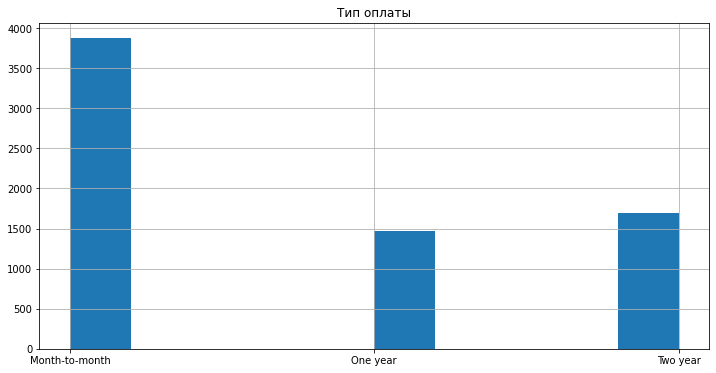

In [6]:
contract['Type'].hist(figsize=(12,6))
plt.title('Тип оплаты');

На графике видно что большинство клиентов выбирают платить каждый месяц, так же видно что клиентов которые оплачивают сразу на 2 года, больше чем те которые оплачивают на год, возможно это связанно с более лояльными условиями предоставляемые тем кто оплачивает 2 года.

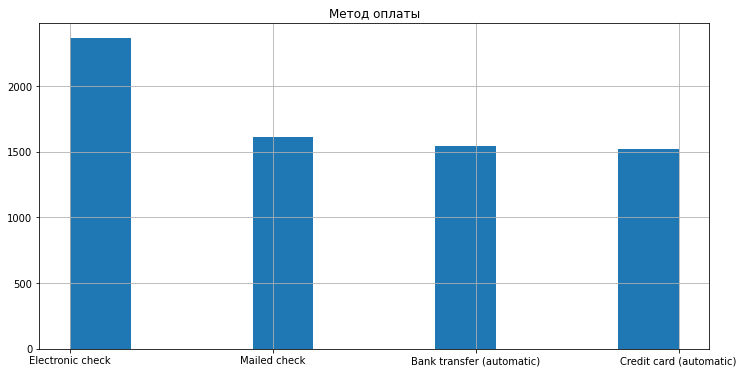

In [7]:
contract['PaymentMethod'].hist(figsize=(12,6))
plt.title('Метод оплаты');

Электронную оплату выбирают чаше всего, это логично, так как это самый удобный способ оплаты.

Попробуем построить сводную таблицу с парой значения, тип оплаты - стоимость.

In [8]:
contract.pivot_table(index='Type', values='MonthlyCharges')

,MonthlyCharges
Type,
Month-to-month,66.398490
One year,65.048608
Two year,60.770413


Таблица выглядит логично, чем больше срок оплаты тем меньше цена, но тут нет учета доп. услуг которые так же влияют на цену.

<AxesSubplot:>

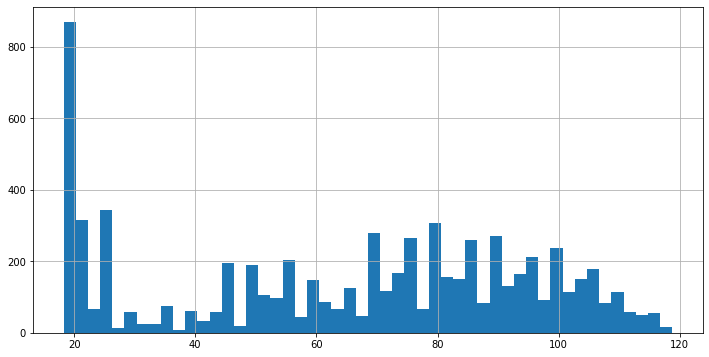

In [9]:
# Взгляним на распределение признака `MonthlyCharges`
contract['MonthlyCharges'].hist(bins=50, figsize=(12,6))

Выглядит он странно, есть выброс в значениях >20, и вообще признак хранит очень много значений.

Признак `TotalCharges` должен хранить совсем разные значения, взависимости от продолжительности пользования клиентом услугами компаниями.

**Вывод :**

Датасет необходим в предобработке, необходимо изменить тип данных, в колонках `BeginDate`, `EndDate` - на `datetime` и `MonthlyCharges`, `TotalCharges` на `float`

Пользователи подключатся и отключаются 1го числа месяца.

Необходимо подробнее изучить ежемесячную оплату, изучить выброс в ней и распредение.

### personal

Перейдем к слейдующему набору данных `personal`.

In [10]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


В данных присутсвуюет каждый пользователь.

Првоерим теже ли это пользователи.

In [12]:
personal.index == contract.index

array([ True,  True,  True, ...,  True,  True,  True])

Датасет не такого большего содержания, в нем можно оценить распределение, каждого параметра.

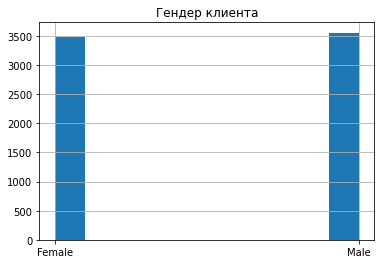

In [13]:
personal['gender'].hist()
plt.title('Гендер клиента');

Гендеры, распределены почти поровну.

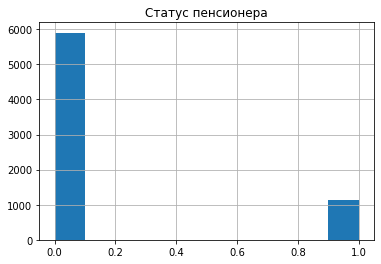

In [14]:
personal['SeniorCitizen'].hist()
plt.title('Статус пенсионера');

Стариков значительно меньше.

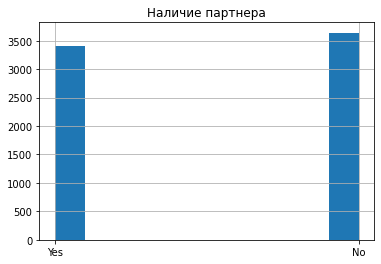

In [15]:
personal['Partner'].hist()
plt.title('Наличие партнера');

Не большой перевес в пользу холостяков.

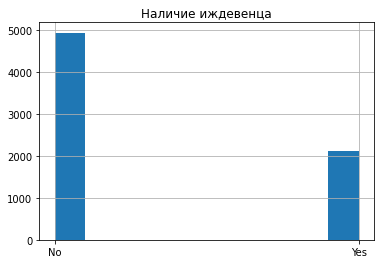

In [16]:
personal['Dependents'].hist()
plt.title('Наличие иждевенца');

Так же виден перевес в сторону клиентов у которых 

**Вывод :**

В датасете о персональных данных, мы посмотрели на распределение в каждой категории среди пользователей, по этим данным можно сложить впечатление какие пользователи чаще является клиентами оператора. 

### internet

Слейдующем дата сетом будет `internet`

In [17]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


В этом наборе данных присутсвуют уже не все пользователи, что логично так как не все подключают у одного и того же оператора мобильную связь и домашний интернет, в следующем дата сете ситуация с отсутсвием какого-то колличества пользователей должна повториться.

В данных присутсвует бинарная классификация внутри каждого признака, посмотрим на каждый признак отдельно.

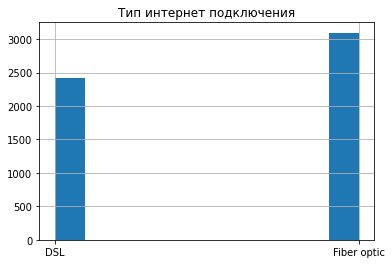

In [19]:
internet['InternetService'].hist()
plt.title('Тип интернет подключения');

Оптоволокно выбирают чаще.

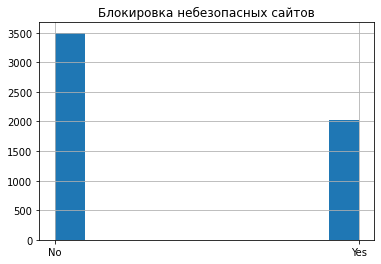

In [20]:
internet['OnlineSecurity'].hist()
plt.title('Блокировка небезопасных сайтов');

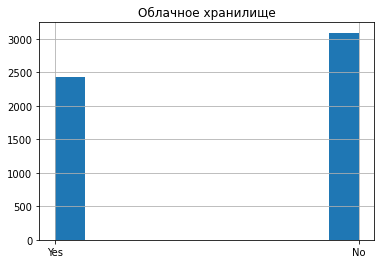

In [21]:
internet['OnlineBackup'].hist()
plt.title('Облачное хранилище');

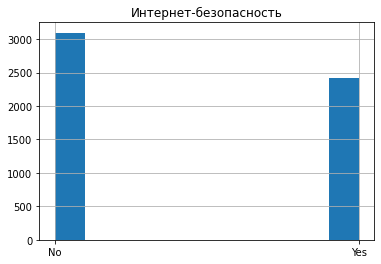

In [22]:
internet['DeviceProtection'].hist()
plt.title('Интернет-безопасность');

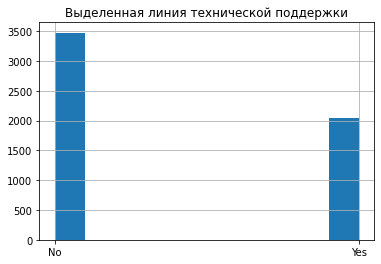

In [23]:
internet['TechSupport'].hist()
plt.title('Выделенная линия технической поддержки');

Пользователи чаще отказываються от доп. услуг для безопастности.

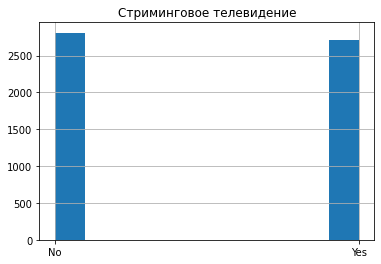

In [24]:
internet['StreamingTV'].hist()
plt.title('Стриминговое телевидение');

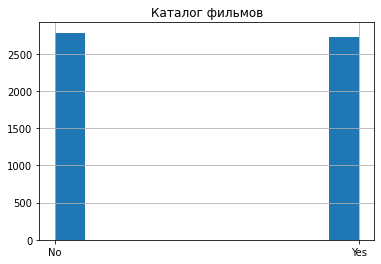

In [25]:
internet['StreamingMovies'].hist()
plt.title('Каталог фильмов');

В стриминговых услугах почти равное распределение пользователей.

**Вывод :**

У большенства пользователей, подключен оптоволоконный кабель, DSL обладает меньшей скоростью и его ставят обычно там где нет возможности провести оптоволоконный кабель например в частных домах. 

Пользователи чаще выбирают отказаться, от доп услуг, что логично обычно пользователя уже стоят какие-то антивирусы или пользователь отдает свое предпочтение другим, а кто-то возможно вообще не знает, для чего они).

Но с стрименговыми сервисами дела обстоят немного по другому примерно поровну распределены, те кто подключают и не подключат, что тоже как мне кажеться логичным, так как обычно тв подключают в месте с интернетом, а кому-то тв не нужен и пользуются, только интернетом.

### phone

Финальный датасет содержит информацию о пользователях у которых подключена возможности ведения параллельных линий во время звонка

In [26]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [27]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Так же не все пользователи попали в данные.

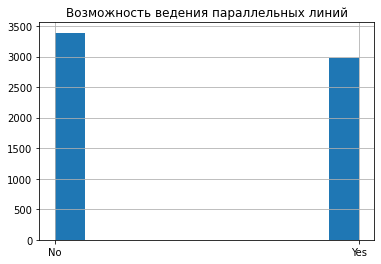

In [28]:
phone['MultipleLines'].hist()
plt.title('Возможность ведения параллельных линий');

**Вывод :**

Не большой перевес, в стороону пользователей у которых отсутсвует данная функция.

# Предобработка

Добавим колонку с целевым признаком, отражающий факт ухода уклиента.

In [29]:
contract['Churn'] = (contract['EndDate'] != 'No').astype(int)

In [30]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Перобразуем тип данных у признаков `BeginDate`, `EndDate`, `MonthlyCharges`, `TotalCharges`

In [31]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

contract['MonthlyCharges'] = contract['MonthlyCharges'].astype(float)

В признаке `EndDate` значение "No" заполним финальной датой датасета и поменяем тип данных.

In [32]:
contract['EndDate'] = contract['EndDate'].where(contract['EndDate'] != 'No', '2020-02-01')

contract['EndDate'] = pd.to_datetime(contract['EndDate'])

Перед тем как продолжить измененять тип данных, заполним пропуски в признаке `TotalCharges`

In [33]:
contract.query('TotalCharges ==  " "')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0


In [34]:
contract.loc[contract['TotalCharges'] == " ", 'TotalCharges'] = 0

In [35]:
# Проверим результат
contract.query('TotalCharges ==  " "')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,


In [36]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [37]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 495.2+ KB


### Добавление признаков и объединение данных

In [38]:
data = contract.copy()

#### Создание периода

Выделим признак, какой период (в днях) пользователь пользовался услугами заказчика на момент 2020-02-01.

In [39]:
data['Period'] = (data['EndDate'] - data['BeginDate']).dt.days

In [40]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Period
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


#### Объедениние данных

В таблицы `internet` и `phone` добавим по признаку, что бы при собирании одного датасета, у нас были пометки у пользователей кто какими услугами пользуется.

In [41]:
internet['Internet'] = 1
phone['Phone'] = 1

In [42]:
data = data.join(personal)
data = data.join(internet)
data = data.join(phone)

Заполним образовавшиеся пропуски

In [43]:
data = data.fillna('No')

In [44]:
data.isna().mean()

BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
Period              0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Internet            0.0
MultipleLines       0.0
Phone               0.0
dtype: float64

Датасет готов для исследовальского анализа.

### Распределение целевого признака

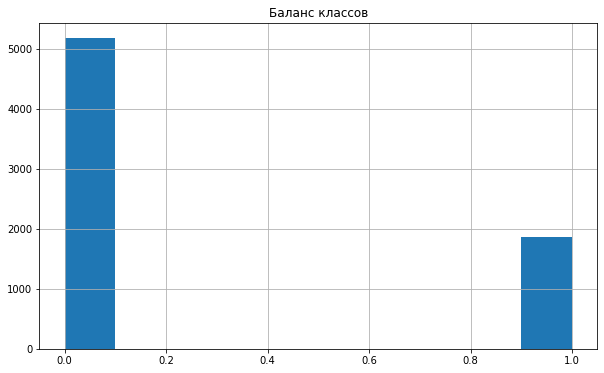

In [45]:
data['Churn'].hist(figsize=(10,6))
plt.title('Баланс классов');

Значительный перевес в сторону пользователей, которые еще пользуются услугами заказчика.

### Ежемесячные платежи

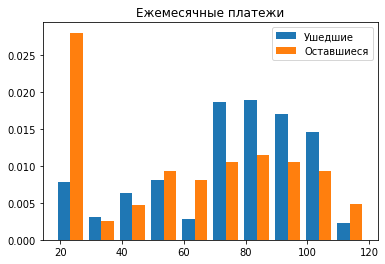

In [46]:
plt.hist([data[data.Churn == 1].MonthlyCharges, data[data.Churn == 0].MonthlyCharges], label=['Ушедшие', 'Оставшиеся'], density=True);
plt.legend();
plt.title('Ежемесячные платежи');
plt.show();

На графике видно что плоность ушедших клиентов больше у дорогих клиентов, у которых ежемесячный платеж от 70 до 100

### Распределение услуг

Посмотрим какие клиенты заказчика чаше выбирают услуги

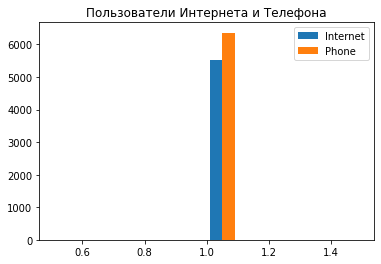

In [47]:
plt.hist([data[data.Internet == 1].Internet, data[data.Phone == 1].Phone], label=['Internet', 'Phone']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Заказчик в первую очередь выступает, телефонным оператором, а уже потом как интернет провайдером.


### Распределение платежей

Взгляним на распределение ежемесячных платежей

<AxesSubplot:>

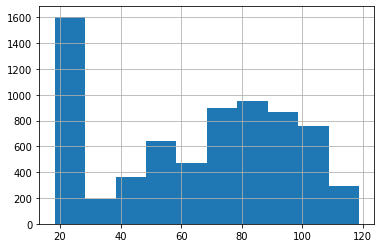

In [48]:
data['MonthlyCharges'].hist()

Видно большое колличество людей которые платят меньше 30

Выделим этих клиентов и посмотри на них поподробнее.

In [49]:
low_charges = data.query('MonthlyCharges < 30')

In [50]:
low_charges.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Period,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
2545-LXYVJ,2014-02-01,2020-02-01,Two year,No,Bank transfer (automatic),20.70,1492.1,0,2191,Male,...,No,No,No,No,No,No,No,No,No,1.0
4195-PNGZS,2014-05-01,2020-02-01,Two year,No,Bank transfer (automatic),24.45,1718.2,0,2102,Male,...,No,No,No,No,No,No,No,No,Yes,1.0
4957-SREEC,2014-04-01,2020-02-01,Two year,No,Credit card (automatic),20.35,1458.1,0,2132,Male,...,No,No,No,No,No,No,No,No,No,1.0
2739-CCZMB,2019-09-01,2020-02-01,Month-to-month,No,Credit card (automatic),20.35,122.0,0,153,Male,...,No,No,No,No,No,No,No,No,No,1.0
3823-KYNQY,2019-02-01,2020-02-01,One year,No,Credit card (automatic),24.95,280.4,0,365,Male,...,No,No,No,No,No,No,No,No,Yes,1.0


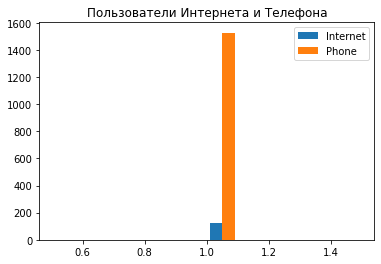

In [51]:
plt.hist([low_charges[low_charges.Internet == 1].Internet, low_charges[low_charges.Phone == 1].Phone], label=['Internet', 'Phone']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Очередное доказательсво что у заказчика клиенты в основном это пользователи сотовой связи.

# Подготовка к обучению модели.

In [52]:
SEED = 290822
KFOLD = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)

### Получение разных датасетов

Создадим датасеты с разным колличеством параметров.

`data_one` - будет основным из него мы уберем только даты.

Из `data_two` уберем параметры связанные с доп.услугами

In [53]:
data_one = data.drop(['BeginDate', 'EndDate'], axis=1)

data_two = data.drop(['BeginDate', 'EndDate', 'InternetService',	'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies', 'MultipleLines'], axis=1)

### Кодировка признаков

Закодируем категоральные признаки.

In [54]:
 data_one = data_one.join(pd.get_dummies(data_one.select_dtypes(include=['object'])))

 data_one = data_one.drop(data_one.select_dtypes(include=['object']), axis=1)

In [55]:
 data_two = data_two.join(pd.get_dummies(data_two.select_dtypes(include=['object'])))
    
 data_two = data_two.drop(data_two.select_dtypes(include=['object']), axis=1)

In [56]:
X = data_one.drop(['Churn'], axis = 1 )

X1 = data_two.drop(['Churn'], axis = 1)

y = data_one['Churn']

### Визуализация

Визуализируем важность признаков.

In [57]:
def plot_features(model,data, target, column_names, model_type):
  
  model.fit(data,target)

  pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score').plot(kind='barh', grid=True,figsize=(10,10), legend=False)

Визуализируем полный датасет.

scores = [0.83199514 0.83526183 0.83664006 0.83810985 0.8301415 ] 
mean score = 0.83443 +/- 0.00295


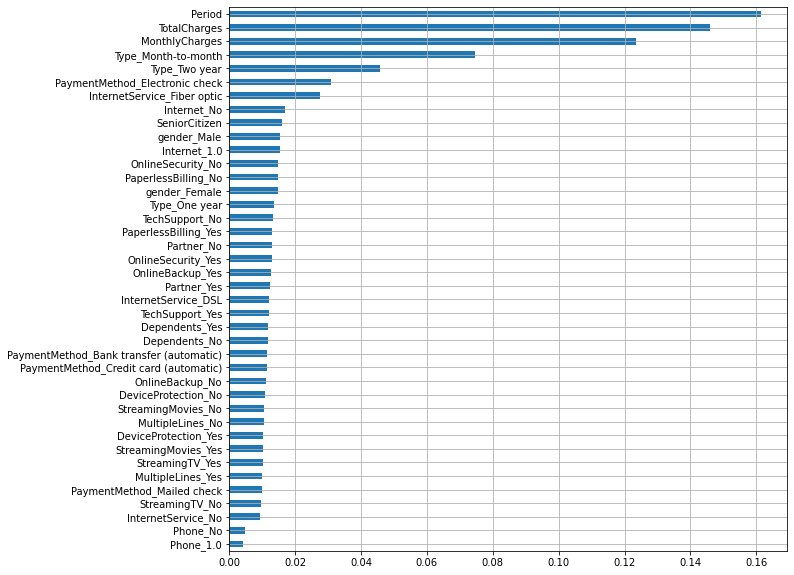

In [58]:
rf = Pipeline([('rf', RandomForestClassifier(n_jobs=-1, 
                                             class_weight='balanced', 
                                             random_state=SEED))])


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scores = cross_val_score(estimator=rf, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

# важность признаков
plot_features(model=rf, data=X, target=y, column_names=X.columns, model_type='rf')

На графике видно влияние каждого признака на обучения, топ 3 признака это:


- `Period` -  какой срок клиент пользуеться услугами

- `MonthlyCharges` - Размер ежемесячного платежа

- `TotalCharges` - Общая сумма за весь срок пользования услугами заказчика

### Разбиение данных.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=SEED)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

### Масштабируем признаки методом стандартизации.

In [60]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Period']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])

/tmp/ipykernel_109/3071693714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric] = scaler.transform(X_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


# Обучение моделей.

### RandomForestClassifier

In [61]:
model_forest = RandomForestClassifier(random_state=SEED, n_estimators=100, max_depth=12)
model_forest.fit(X_train, y_train)
pred_proba_forest = model_forest.predict_proba(X_valid)[:, 1]
print('ROC-AUC: ',roc_auc_score(y_valid, pred_proba_forest))

ROC-AUC:  0.84761776609835


### LogisticRegression

In [62]:
model_log = LogisticRegression(random_state=SEED, solver='liblinear')
model_log.fit(X_train, y_train)
pred_proba_log = model_log.predict_proba(X_valid)[:, 1]
print('ROC-AUC: ',roc_auc_score(y_valid, pred_proba_log))

ROC-AUC:  0.8350456711361586


### CatBoostClassifier

In [63]:
model_cat = CatBoostClassifier(random_state=SEED)
model_cat.fit(X_train, y_train)
pred_proba_cat = model_cat.predict_proba(X_valid)[:, 1]
print('ROC-AUC: ',roc_auc_score(y_valid, pred_proba_cat))

Learning rate set to 0.019062
0:	learn: 0.6800545	total: 50.1ms	remaining: 50s
1:	learn: 0.6671513	total: 53.1ms	remaining: 26.5s
2:	learn: 0.6545093	total: 56ms	remaining: 18.6s
3:	learn: 0.6427050	total: 58.9ms	remaining: 14.7s
4:	learn: 0.6309536	total: 62ms	remaining: 12.3s
5:	learn: 0.6202817	total: 64.8ms	remaining: 10.7s
6:	learn: 0.6103775	total: 67.7ms	remaining: 9.6s
7:	learn: 0.6006383	total: 70.8ms	remaining: 8.78s
8:	learn: 0.5905158	total: 73.8ms	remaining: 8.12s
9:	learn: 0.5820397	total: 76.7ms	remaining: 7.59s
10:	learn: 0.5740072	total: 78.6ms	remaining: 7.06s
11:	learn: 0.5662454	total: 81.6ms	remaining: 6.72s
12:	learn: 0.5587270	total: 84.6ms	remaining: 6.43s
13:	learn: 0.5526566	total: 87.7ms	remaining: 6.18s
14:	learn: 0.5459617	total: 90.7ms	remaining: 5.95s
15:	learn: 0.5396605	total: 93.8ms	remaining: 5.76s
16:	learn: 0.5331848	total: 96.7ms	remaining: 5.59s
17:	learn: 0.5276575	total: 99.6ms	remaining: 5.43s
18:	learn: 0.5216359	total: 103ms	remaining: 5.29s


In [64]:
table = pd.DataFrame({'Model': ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier'], 'ROC-AUC':[0.84761776609835, 0.8350456711361586,0.8893497337829208]}).sort_values('ROC-AUC', ascending=False)

In [65]:
table

,Model,ROC-AUC
2,CatBoostClassifier,0.889350
0,RandomForestClassifier,0.847618
1,LogisticRegression,0.835046


Лучший результат показала модель CatBoostClassifier - 0.88, в дальнейшем будем использовать catboost

Необходимо понять насколько хороший это результат.

Взгляним еще раз на баланс классов.

0    0.73463
1    0.26537
Name: Churn, dtype: float64


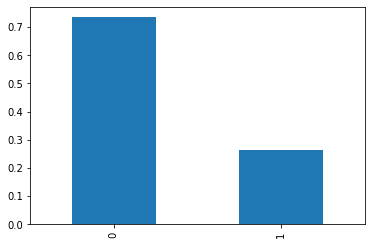

In [66]:
class_exited = data['Churn'].value_counts(normalize=True)
class_exited.plot(kind='bar');
print(class_exited)

Классы не сбалансированы, клиент уходит в ~26% случаев

Посмотрим на частоты в предсказанний моделей.

0    0.801278
1    0.198722
dtype: float64


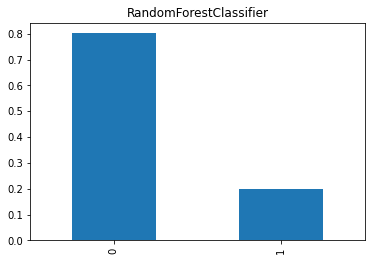

In [67]:
class_exited = pd.Series(model_forest.predict(X_valid)).value_counts(normalize=True)
class_exited.plot(kind='bar');
plt.title('RandomForestClassifier')
print(class_exited)

0    0.784244
1    0.215756
dtype: float64


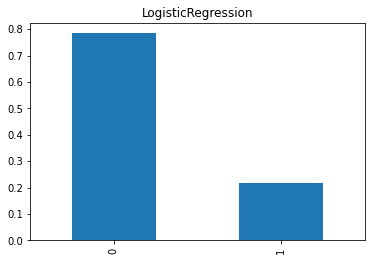

In [68]:
class_exited = pd.Series(model_log.predict(X_valid)).value_counts(normalize=True)
class_exited.plot(kind='bar');
plt.title('LogisticRegression')
print(class_exited)

0    0.79489
1    0.20511
dtype: float64


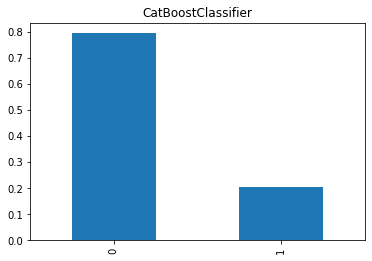

In [69]:
class_exited = pd.Series(model_cat.predict(X_valid)).value_counts(normalize=True)
class_exited.plot(kind='bar');
plt.title('CatBoostClassifier')
print(class_exited)

Модели предсказывают уход клиента в 20% случаев

Сравним с константной моделью, для оценки адекватности модели.

In [70]:
const = pd.Series(0, y.index)
accuracy_score(y, const)

0.7346301292063041

Построенные модели предсказывают уход клиентов лучше, чем константная модель, они адекватны.


# Борьба с дисбалансом

Попробуем разные методы борьбы с дисбалансом.

### Увелечение выборки

In [71]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones]* repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones]* repeat )
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=SEED)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(X_train, y_train, 5)

In [72]:
model_cat = CatBoostClassifier(random_state=SEED)
model_cat.fit(features_upsampled, target_upsampled)
pred_proba_up = model_cat.predict_proba(X_valid)[:, 1]

Learning rate set to 0.025939
0:	learn: 0.6772287	total: 5.82ms	remaining: 5.81s
1:	learn: 0.6623528	total: 11.1ms	remaining: 5.56s
2:	learn: 0.6507609	total: 16.4ms	remaining: 5.47s
3:	learn: 0.6390748	total: 21.8ms	remaining: 5.42s
4:	learn: 0.6273397	total: 27ms	remaining: 5.37s
5:	learn: 0.6170669	total: 32ms	remaining: 5.3s
6:	learn: 0.6074726	total: 37.1ms	remaining: 5.26s
7:	learn: 0.5977984	total: 42.3ms	remaining: 5.24s
8:	learn: 0.5893918	total: 47.3ms	remaining: 5.21s
9:	learn: 0.5816270	total: 52.4ms	remaining: 5.19s
10:	learn: 0.5755536	total: 55.9ms	remaining: 5.03s
11:	learn: 0.5690108	total: 59.5ms	remaining: 4.9s
12:	learn: 0.5617120	total: 63.1ms	remaining: 4.79s
13:	learn: 0.5559428	total: 66.7ms	remaining: 4.7s
14:	learn: 0.5505133	total: 70.2ms	remaining: 4.61s
15:	learn: 0.5453938	total: 74ms	remaining: 4.55s
16:	learn: 0.5398574	total: 78.2ms	remaining: 4.52s
17:	learn: 0.5346239	total: 82.1ms	remaining: 4.48s
18:	learn: 0.5296222	total: 85.9ms	remaining: 4.43s
1

In [73]:
roc_auc_score(y_valid, pred_proba_up)

0.8915013693425573

### Уменьшение выборки

In [74]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(X_train, y_train, 0.24)

In [75]:
model_cat = CatBoostClassifier(random_state=SEED)
model_cat.fit(features_downsampled, target_downsampled)
pred_proba_down = model_cat.predict_proba(X_valid)[:, 1]

Learning rate set to 0.013437
0:	learn: 0.6858307	total: 2.65ms	remaining: 2.65s
1:	learn: 0.6788759	total: 5.41ms	remaining: 2.7s
2:	learn: 0.6731225	total: 7.85ms	remaining: 2.61s
3:	learn: 0.6668172	total: 11.4ms	remaining: 2.83s
4:	learn: 0.6602804	total: 15.1ms	remaining: 3.01s
5:	learn: 0.6541357	total: 18.8ms	remaining: 3.12s
6:	learn: 0.6482026	total: 22.7ms	remaining: 3.22s
7:	learn: 0.6428411	total: 26.1ms	remaining: 3.24s
8:	learn: 0.6370704	total: 28.6ms	remaining: 3.15s
9:	learn: 0.6324669	total: 31.3ms	remaining: 3.1s
10:	learn: 0.6270381	total: 33.7ms	remaining: 3.03s
11:	learn: 0.6221428	total: 36ms	remaining: 2.97s
12:	learn: 0.6175715	total: 38.4ms	remaining: 2.92s
13:	learn: 0.6135977	total: 40.9ms	remaining: 2.88s
14:	learn: 0.6095677	total: 43.3ms	remaining: 2.84s
15:	learn: 0.6050663	total: 45.8ms	remaining: 2.81s
16:	learn: 0.6010850	total: 48.4ms	remaining: 2.8s
17:	learn: 0.5971747	total: 50.9ms	remaining: 2.78s
18:	learn: 0.5931065	total: 53.4ms	remaining: 2.7

In [76]:
roc_auc_score(y_valid, pred_proba_down)

0.8679639802223665

Увелечение выборки помогло немного повысить качество модели, уменьшение выборки на оборот отрицательно влияет на результат.

# Тестирование модели.

Проведем обучение на увеличенной выборке, и проверим метрику ROC-AUC на тестовой выборке.

In [77]:
model_cat = CatBoostClassifier(random_state=SEED)
model_cat.fit(features_upsampled, target_upsampled)
pred_proba_up = model_cat.predict_proba(X_test)[:, 1]

Learning rate set to 0.025939
0:	learn: 0.6772287	total: 3.82ms	remaining: 3.82s
1:	learn: 0.6623528	total: 7.71ms	remaining: 3.85s
2:	learn: 0.6507609	total: 11.4ms	remaining: 3.78s
3:	learn: 0.6390748	total: 15.1ms	remaining: 3.75s
4:	learn: 0.6273397	total: 18.6ms	remaining: 3.7s
5:	learn: 0.6170669	total: 22.3ms	remaining: 3.69s
6:	learn: 0.6074726	total: 26ms	remaining: 3.69s
7:	learn: 0.5977984	total: 29.8ms	remaining: 3.69s
8:	learn: 0.5893918	total: 33.5ms	remaining: 3.68s
9:	learn: 0.5816270	total: 37.2ms	remaining: 3.68s
10:	learn: 0.5755536	total: 39.8ms	remaining: 3.58s
11:	learn: 0.5690108	total: 43.4ms	remaining: 3.57s
12:	learn: 0.5617120	total: 46.9ms	remaining: 3.56s
13:	learn: 0.5559428	total: 50.5ms	remaining: 3.56s
14:	learn: 0.5505133	total: 54ms	remaining: 3.55s
15:	learn: 0.5453938	total: 57.5ms	remaining: 3.53s
16:	learn: 0.5398574	total: 61.1ms	remaining: 3.53s
17:	learn: 0.5346239	total: 64.8ms	remaining: 3.54s
18:	learn: 0.5296222	total: 68.3ms	remaining: 3.5

In [78]:
roc_auc_score(y_test, pred_proba_up)

0.8976900430286102

# ROC AUC

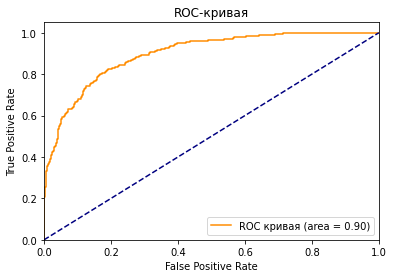

ROC_AUC Метрика:  0.8976900430286102


In [79]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba_up)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()
print('ROC_AUC Метрика: ',roc_auc_score(y_test, pred_proba_up))

# Общий вывод:



В ходе работы был выполнено: 

- предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет
- были прочитаны  данные   и по ним были сделаны предварительные выводы
- произведена первичная обработка данных - переименованы столбцы, изменены типы данных
- добавлены 2 новых столбца - целевой признак Churn, который означает отказался ли клиент от услуг и TotalDays, который обозначает сколько по времени пользователь пользовался услугами
- проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком
- сделаны выводы: со временем вероятность отказа от услуг снижается и обычно отказывались от услуг те, кто платил больше
- проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен upsample
- обучены 3 модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier



В результате обучения лучше все себя показала модель `CatBosstClassifier` и на ней же была достигнута метрика ROC_AUC = 0.891
Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц